# NTC Simulation

In this file, the choice for the NTC linearization is made.

Change V to test other voltages

$$R_{ntc} = R_0 \cdot exp(\beta\cdot(\frac{1}{T} - \frac{1}{Tref}))$$

Note that the circuit used is the following:
        ______
Vcc ---| Rntc |----|---- Vout
       --------    | 
                 |---|
                 | Rs|
                 |___|
                   |
                   |
                  GND


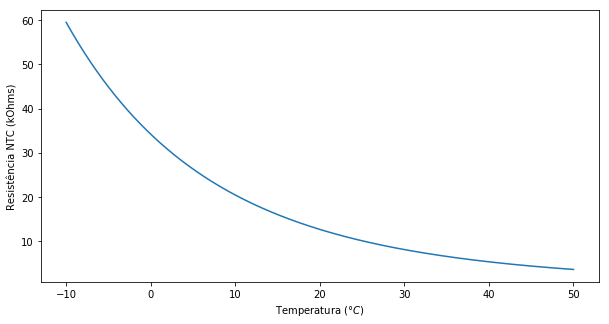

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Values for NTC
R0 = 10e3
beta = 3978.52         # Datasheet: 3435, this one is the calculated one.
Tref = 25 + 273.15    # In Kelvin

# Voltage for power calculation
V = 3.0

T = np.linspace(-10, 50, 500)

# Compute NTC resistance based on temperature
Rntc = R0 * np.exp( beta * ((1/(T+273)) - (1/Tref)) )

plt.plot(T, Rntc/1000)
plt.xlabel("Temperatura ($\degree C$)")
plt.ylabel("Resistência NTC (kOhms)")
plt.show()


# Plotting

In this cell, the curve for Vout is plotted against a linearized one (around 25 C), and against a 3rd order polynomial.

Errors, power dissipation and temperature are plotted as well.

To test new resistance values for Rs, add it to Rs_values List.

In [21]:
Rs_ideal = 10e3 * (beta - 2*Tref)/(beta + 2*Tref)
Rs_ideal

7393.121478003507

Slope:0.010839220483507505
 b: 0.14035297102337552
error 2 = 0.0005248370191084935


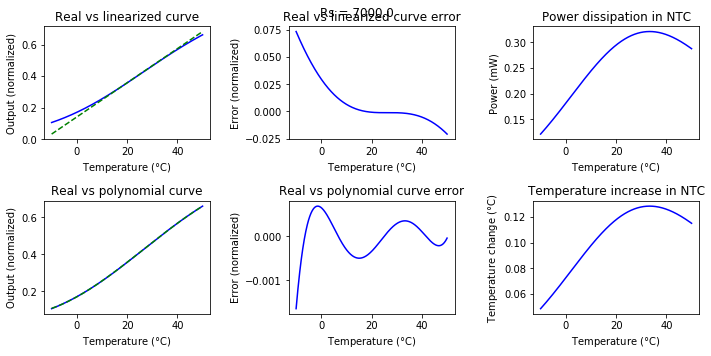

Slope:0.011196456387147665
 b: 0.21964343688969057
error 2 = 0.00022748894984953534


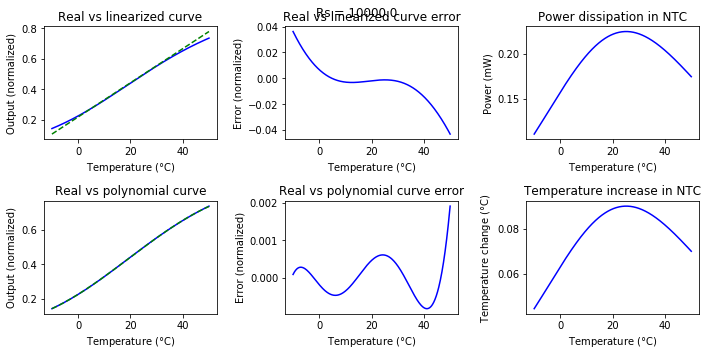

In [22]:
# Possible values for Rs
Rs_values = [7.0e3, 10e3]

for Rs in Rs_values:
    # Compute Vout based on NTC and 
    Vout = Rs/(Rs+Rntc)

    # Get slope at 25 C
    linearize_point = int(np.where( (T > 25.0) & (T<25.12))[0])
    
    slopeT = (Vout[linearize_point] - Vout[linearize_point - 1]) / (T[linearize_point]-T[linearize_point-1])
    bT = Vout[linearize_point]-slopeT*25
    
    print("Slope:{}\n b: {}".format(slopeT, bT))

    # Linearize around 25 C
    linVout = slopeT*T + bT
    

    # Make a 3rd order polynomial for approx
    z = np.polyfit(T,Vout,3)  # Vout(T)
    Vout_T = np.poly1d(z)
    
    z2 = np.polyfit(Vout,T,3)  # T(Vout)
    T_Vout = np.poly1d(z2)

    # Start plotting figures
    
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.figure()

    plt.suptitle('Rs = {}'.format(Rs))

    
    # --- Real and linearized curve
    plt.subplot(2,3,1)

    # Plot real curve
    plt.plot(T, Vout, 'b')
    # Plot linearized curve
    plt.plot(T, linVout, 'g--')
    plt.xlabel('Temperature ($\degree$C)')
    plt.ylabel('Output (normalized)')

    plt.title('Real vs linearized curve')

    # --- Real and linearized curve error
    plt.subplot(2,3,2)

    # Plot error curve
    plt.plot(T, (Vout - linVout), 'b')

    plt.title('Real vs linearized curve error')

    plt.xlabel('Temperature ($\degree$C)')
    plt.ylabel('Error (normalized)')
    
    print("error 2 = {}".format(np.mean((Vout-linVout)**2)))
    
    plt.subplot(2,3,3)

    # Plot power on NTC
    PowerNTC = ((V**2)*(1-Vout)/(Rs+Rntc))*1000
    plt.plot(T, PowerNTC, 'b')

    plt.title('Power dissipation in NTC')

    plt.xlabel('Temperature ($\degree$C)')
    plt.ylabel('Power (mW)')

    # --- Real and polynomial approximation
    plt.subplot(2,3,4)

    # Plot real curve
    plt.plot(T, Vout, 'b')
    # Plot polynomial curve
    plt.plot(T, Vout_T(T), 'g--')

    plt.xlabel('Temperature ($\degree$C)')
    plt.ylabel('Output (normalized)')

    plt.title('Real vs polynomial curve')

    # --- Real and polynomial approximation error
    plt.subplot(2,3,5)

    # Plot real curve
    plt.plot(T, (Vout - Vout_T(T)), 'b')

    plt.title('Real vs polynomial curve error')
    plt.xlabel('Temperature ($\degree$C)')
    plt.ylabel('Error (normalized)')
    
    # Plot temperature increase on NTC
    plt.subplot(2,3,6)
    powerDissipation = 2.5 # mW/C
    plt.plot(T, PowerNTC/powerDissipation, 'b')

    plt.title('Temperature increase in NTC')

    plt.xlabel('Temperature ($\degree$C)')
    plt.ylabel('Temperature change ($\degree$C)')

    plt.tight_layout()
    plt.show()


# Experimental values

Here are some experimental values I got to calibrate the NTC. 

These measures are not perfect (I measured the resistance of the NTC instead of the ADC output directly), but they should be close.

The temperatures were measured using a kitchen thermometer.

Below you can check the resulting resistance, as well as the theoretical error for each sensor.


| Temperature (C) | Resistance (kOhms) | Error (C) |
|:---------------:|:------------------:|:---------:|
|        0        |        31.5        |    1.47   |
|        20       |        12.38       |    0.48   |
|       82.1      |        1.04        |   -5.03   |

You can check more detailed information as well as the calculations for Beta in the spreadsheet NTC_calibration.ods


You could also check some real-world data in the data folder!


In [23]:
adc_0c = 10/(10+31.5)    # Ice bath
adc_20c = 10/(10+12.38)  # Room temp
adc_821c = 10/(10+1.04)  # Hot water water

print(T_Vout(adc_0c)-0)
print(T_Vout(adc_20c)-20)
print(T_Vout(adc_821c)-82.1)

1.4671289748022431
0.4786230809880152
-5.027602373844857
